# Image Classification challange AN2DL Politecnico di Milano 2022
This is ..


## Define the environment
1. **Colab**: the notebook must be in a folder where there is a folder called `data` and the `zip` file containing the training data inside (i.e. `data/training_dataset_homework1.zip`).
2. **Local**: extract the `zip` file containing the training data in `data/training_data_final`

In [1]:
IS_COLAB = True
COLAB_BASE_DIR = '/gdrive/MyDrive/colab/AN2DL1/'
USE_WHOLE_DATASET = True # if True do not perform validation and analysis, just train with all the data

## Libraries import

In [2]:
import os
import enum
import json
from datetime import datetime
import random
from typing import Tuple, Callable, Dict, Optional, List

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Check device
tf.test.gpu_device_name()

'/device:GPU:0'

### Seed

In [3]:
# Random seed for reproducibility
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED) 

### Mount Google Drive (if using Colab)

In [4]:
if IS_COLAB:
    from google.colab import drive
    drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Check folders

In [5]:
ROOT_DIR = os.getcwd()
DATA_DIR = 'data/training_data_final'

if IS_COLAB:
  if not os.path.exists('data'):
    !mkdir 'data'
  if not os.path.isfile('data/training_dataset_homework1.zip'):
    zip_source = COLAB_BASE_DIR + 'data/training_dataset_homework1.zip'
    !cp $zip_source 'data'
  if not os.path.exists(DATA_DIR):
    !unzip 'data/training_dataset_homework1' -d 'data'
else:
  if not os.path.exists('data'):
    raise RuntimeError("data/training_data_final path not found.")
  if not os.path.exists(DATA_DIR):
    raise RuntimeError("please unzip data/training_dataset_homework1.zip")

## Load datasets

Define datasets hyperparameters

In [6]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64

In [10]:
IMG_SIZE = (96, 96)
IMG_SHAPE = IMG_SIZE + (3,)
N_CLASSES = 8

if USE_WHOLE_DATASET:
    complete_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=SEED,
    )

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset = 'training'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset = 'validation'
)

Found 3542 files belonging to 8 classes.
Found 3542 files belonging to 8 classes.
Using 2834 files for training.
Found 3542 files belonging to 8 classes.
Using 708 files for validation.


Configure the dataset for performance, see the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide:

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

if USE_WHOLE_DATASET:
  complete_ds = complete_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
else:
  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Preprocessing and Data Augmentation

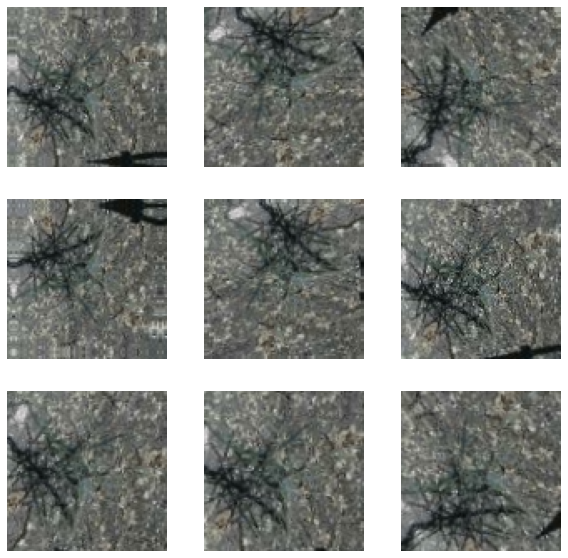

In [12]:


data_augmentation_layer = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  #tf.keras.layers.RandomContrast(0.1),
  #tf.keras.layers.RandomBrightness(0.01),
  tf.keras.layers.RandomZoom(0.1),
  #tf.keras.layers.RandomTranslation(0.1, 0.1)
], name='data_augmentation')

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation_layer(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Base model

In [13]:
if USE_WHOLE_DATASET:
  BASE_MODEL_EPOCHS = 70

BASE_MODEL_LEARNING_RATE = 1e-3
BASE_MODEL_OPTIMIZER = tf.keras.optimizers.Adam(BASE_MODEL_LEARNING_RATE)
BASE_MODEL_LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
BASE_MODEL_EARLY_STOPPING_PATIENCE = 30

In [14]:
base_model_supernet = tf.keras.applications.EfficientNetV2B1(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model_supernet.trainable = False

In [15]:
base_model = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SHAPE, name="input"),
    data_augmentation_layer,
    tf.keras.layers.Lambda(tf.keras.applications.efficientnet_v2.preprocess_input , name="supernet_preprocessing"),
    base_model_supernet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(SEED)),
    tf.keras.layers.Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(SEED)),
    tf.keras.layers.Dense(N_CLASSES, name='output', activation='softmax', kernel_initializer=tf.keras.initializers.GlorotUniform(SEED))
], name="base_model")

In [16]:
base_model.compile(
    optimizer=BASE_MODEL_OPTIMIZER,
    loss=BASE_MODEL_LOSS,
    metrics=['accuracy']
)
base_model.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 96, 96, 3)        0         
 al)                                                             
                                                                 
 supernet_preprocessing (Lam  (None, 96, 96, 3)        0         
 bda)                                                            
                                                                 
 efficientnetv2-b1 (Function  (None, 3, 3, 1280)       6931124   
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                        

### Training

In [17]:
if USE_WHOLE_DATASET:
  base_model_history = base_model.fit(
    complete_ds,
    epochs=BASE_MODEL_EPOCHS
  )
else:
  # use early stopping
  base_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=BASE_MODEL_EARLY_STOPPING_PATIENCE, restore_best_weights=True)
  base_model_history = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks = [base_model_early_stopping],
  )

Epoch 1/70
56/56 [==============================] - 16s 86ms/step - loss: 1.6740 - accuracy: 0.4763
Epoch 2/70
56/56 [==============================] - 4s 79ms/step - loss: 1.0588 - accuracy: 0.6110
Epoch 3/70
56/56 [==============================] - 4s 77ms/step - loss: 0.9684 - accuracy: 0.6505
Epoch 4/70
56/56 [==============================] - 4s 76ms/step - loss: 0.9113 - accuracy: 0.6697
Epoch 5/70
56/56 [==============================] - 5s 89ms/step - loss: 0.8970 - accuracy: 0.6765
Epoch 6/70
56/56 [==============================] - 4s 77ms/step - loss: 0.8190 - accuracy: 0.7036
Epoch 7/70
56/56 [==============================] - 4s 77ms/step - loss: 0.8393 - accuracy: 0.7053
Epoch 8/70
56/56 [==============================] - 4s 78ms/step - loss: 0.8071 - accuracy: 0.7067
Epoch 9/70
56/56 [==============================] - 5s 81ms/step - loss: 0.8124 - accuracy: 0.7103
Epoch 10/70
56/56 [==============================] - 4s 78ms/step - loss: 0.7798 - accuracy: 0.7242
Epoch 11

### Visualize performance

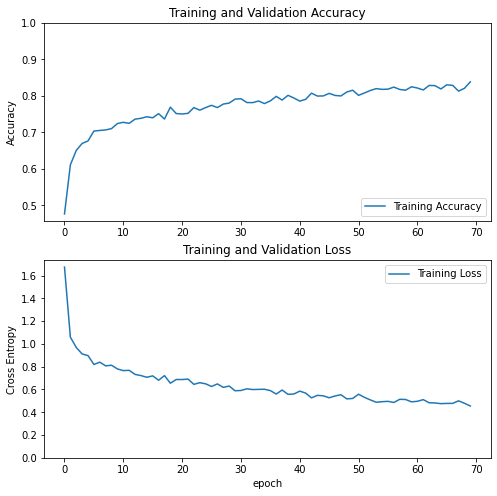

In [18]:
acc = base_model_history.history['accuracy']
if not USE_WHOLE_DATASET:
  val_acc = base_model_history.history['val_accuracy']

loss = base_model_history.history['loss']
if not USE_WHOLE_DATASET:
  val_loss = base_model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
if not USE_WHOLE_DATASET:
  plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
if not USE_WHOLE_DATASET:
  plt.plot([base_model_early_stopping.best_epoch,base_model_early_stopping.best_epoch], plt.ylim(), label='Best Epoch')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
if not USE_WHOLE_DATASET:
  plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,max(plt.ylim())])
if not USE_WHOLE_DATASET:
  plt.plot([base_model_early_stopping.best_epoch,base_model_early_stopping.best_epoch], plt.ylim(), label='Best Epoch')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save model

In [19]:
base_model_directory = f'models/{base_model_supernet.name}-{datetime.today().strftime("%Y-%m-%d-%H-%M-%S")}'
base_model.save(base_model_directory)

## Fine tuning

In [30]:
if USE_WHOLE_DATASET:
  FT_MODEL_EPOCHS = 100

FT_MODEL_LEARNING_RATE = 5e-5
FT_MODEL_OPTIMIZER = tf.keras.optimizers.Adam(FT_MODEL_LEARNING_RATE)
FT_MODEL_LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
FT_MODEL_EARLY_STOPPING_PATIENCE = 20
FT_MODEL_N_UNFREEZE = 50

### Reload model

In [31]:
ft_model = tf.keras.models.load_model(base_model_directory)
ft_model.summary()
print("Number of layers in the supernet: ", len(ft_model.get_layer(base_model_supernet.name).layers))

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 96, 96, 3)        0         
 al)                                                             
                                                                 
 supernet_preprocessing (Lam  (None, 96, 96, 3)        0         
 bda)                                                            
                                                                 
 efficientnetv2-b1 (Function  (None, 3, 3, 1280)       6931124   
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                        

### Unfreeze some layers

In [32]:
ft_model.get_layer(base_model_supernet.name).trainable = True

unfreezed = 0
for i in reversed(range(len(ft_model.get_layer(base_model_supernet.name).layers))):
  layer = ft_model.get_layer(base_model_supernet.name).layers[i]
  if layer.name == 'block6d_se_excite':
      layer.trainable = True
  elif unfreezed < FT_MODEL_N_UNFREEZE and not isinstance(layer, tf.keras.layers.BatchNormalization):
      unfreezed += 1
      layer.trainable = True
  else:
    layer.trainable = False
  
  print(i, layer.name, layer.trainable)


ft_model.summary()

333 top_activation True
332 top_bn False
331 top_conv True
330 block6i_add True
329 block6i_drop True
328 block6i_project_bn False
327 block6i_project_conv True
326 block6i_se_excite True
325 block6i_se_expand True
324 block6i_se_reduce True
323 block6i_se_reshape True
322 block6i_se_squeeze True
321 block6i_activation True
320 block6i_bn False
319 block6i_dwconv2 True
318 block6i_expand_activation True
317 block6i_expand_bn False
316 block6i_expand_conv True
315 block6h_add True
314 block6h_drop True
313 block6h_project_bn False
312 block6h_project_conv True
311 block6h_se_excite True
310 block6h_se_expand True
309 block6h_se_reduce True
308 block6h_se_reshape True
307 block6h_se_squeeze True
306 block6h_activation True
305 block6h_bn False
304 block6h_dwconv2 True
303 block6h_expand_activation True
302 block6h_expand_bn False
301 block6h_expand_conv True
300 block6g_add True
299 block6g_drop True
298 block6g_project_bn False
297 block6g_project_conv True
296 block6g_se_excite True
29

### Compile and train

In [33]:
ft_model.compile(
    optimizer=FT_MODEL_OPTIMIZER,
    loss=FT_MODEL_LOSS,
    metrics=['accuracy']
)
ft_model.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 96, 96, 3)        0         
 al)                                                             
                                                                 
 supernet_preprocessing (Lam  (None, 96, 96, 3)        0         
 bda)                                                            
                                                                 
 efficientnetv2-b1 (Function  (None, 3, 3, 1280)       6931124   
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                        

In [37]:
if USE_WHOLE_DATASET:
  ft_history = ft_model.fit(
    complete_ds,
    epochs=FT_MODEL_EPOCHS,
    initial_epoch=BASE_MODEL_EPOCHS
  )
else:
  # use early stopping
  ft_max_epochs = 100
  ft_total_epochs =  base_model_early_stopping.best_epoch + ft_max_epochs

  ft_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=FT_MODEL_EARLY_STOPPING_PATIENCE, restore_best_weights=True)

  ft_history = ft_model.fit(
      train_ds,
      epochs=ft_total_epochs,
      initial_epoch=base_model_early_stopping.best_epoch,
      validation_data=val_ds,
      callbacks = [ft_early_stopping]
  )

Epoch 71/100
56/56 [==============================] - 5s 87ms/step - loss: 0.2964 - accuracy: 0.8978
Epoch 72/100
56/56 [==============================] - 5s 85ms/step - loss: 0.3110 - accuracy: 0.8831
Epoch 73/100
56/56 [==============================] - 5s 85ms/step - loss: 0.3198 - accuracy: 0.8845
Epoch 74/100
56/56 [==============================] - 5s 85ms/step - loss: 0.2924 - accuracy: 0.8970
Epoch 75/100
56/56 [==============================] - 5s 85ms/step - loss: 0.2956 - accuracy: 0.8907
Epoch 76/100
56/56 [==============================] - 5s 86ms/step - loss: 0.2780 - accuracy: 0.9023
Epoch 77/100
56/56 [==============================] - 5s 86ms/step - loss: 0.3021 - accuracy: 0.8913
Epoch 78/100
56/56 [==============================] - 5s 85ms/step - loss: 0.2734 - accuracy: 0.9034
Epoch 79/100
56/56 [==============================] - 5s 85ms/step - loss: 0.2970 - accuracy: 0.8944
Epoch 80/100
56/56 [==============================] - 5s 84ms/step - loss: 0.2547 - accurac

### Visualize results

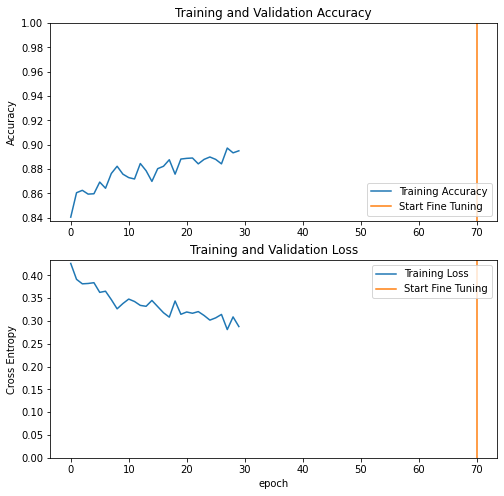

In [35]:
acc = ft_history.history['accuracy']
if not USE_WHOLE_DATASET:
  val_acc += ft_history.history['val_accuracy']

loss = ft_history.history['loss']
if not USE_WHOLE_DATASET:
  val_loss += ft_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
if not USE_WHOLE_DATASET:
  plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
if not USE_WHOLE_DATASET:
  plt.plot([ft_early_stopping.best_epoch,ft_early_stopping.best_epoch],
         plt.ylim(), label='Best Epoch')
if not USE_WHOLE_DATASET:
  plt.plot([base_model_early_stopping.best_epoch, base_model_early_stopping.best_epoch],
          plt.ylim(), label='Start Fine Tuning')
else:
  plt.plot([BASE_MODEL_EPOCHS, BASE_MODEL_EPOCHS],
          plt.ylim(), label='Start Fine Tuning')

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
if not USE_WHOLE_DATASET:
  plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,max(plt.ylim())])
if not USE_WHOLE_DATASET:
  plt.plot([ft_early_stopping.best_epoch,ft_early_stopping.best_epoch],
         plt.ylim(), label='Best Epoch')
if not USE_WHOLE_DATASET:
  plt.plot([base_model_early_stopping.best_epoch, base_model_early_stopping.best_epoch],
          plt.ylim(), label='Start Fine Tuning')
else:
  plt.plot([BASE_MODEL_EPOCHS, BASE_MODEL_EPOCHS],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save model

Save newly trained fine tuned model

In [38]:
ft_model_directory = f'models/{base_model_supernet.name}-finetuned-{datetime.today().strftime("%Y-%m-%d-%H-%M-%S")}'
ft_model.save(ft_model_directory)
if IS_COLAB:
  from shutil import make_archive, copyfile
  make_archive(ft_model_directory, 'zip', ft_model_directory)
  copyfile(ft_model_directory + '.zip', COLAB_BASE_DIR + ft_model_directory)